# Category Classification

In [1]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 32
max_length = 128
num_epochs = 20
learning_rate = 3e-4

Using device: cuda


In [3]:
df = pd.read_csv("../Final_Dataset_Fixed.csv")
df = df[df['category'].isin(['poems', 'stories', 'essays', 'novels'])]  # Filter only valid categories

# Map categories to numerical labels
label_map = {"poems": 0, "stories": 1, "essays": 2, "novels": 3}
df["label"] = df["category"].map(label_map)

texts, labels = df["text"].tolist(), df["label"].tolist()


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


Total category distribution:
 category
novels     6000
essays     6000
stories    6000
poems      6000
Name: count, dtype: int64


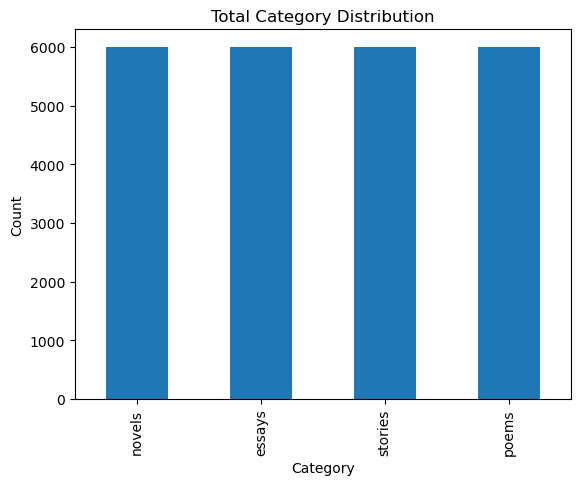

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Check category distribution in full dataset
category_counts = df['category'].value_counts()
print("Total category distribution:\n", category_counts)

# Optional: plot
category_counts.plot(kind='bar', title='Total Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


Train set distribution:
  Class 0: 4800
  Class 1: 4800
  Class 2: 4800
  Class 3: 4800

Validation set distribution:
  Class 0: 600
  Class 1: 600
  Class 2: 600
  Class 3: 600

Test set distribution:
  Class 0: 600
  Class 1: 600
  Class 2: 600
  Class 3: 600



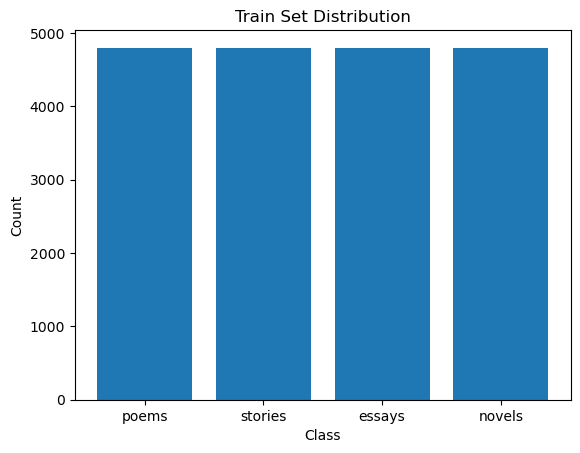

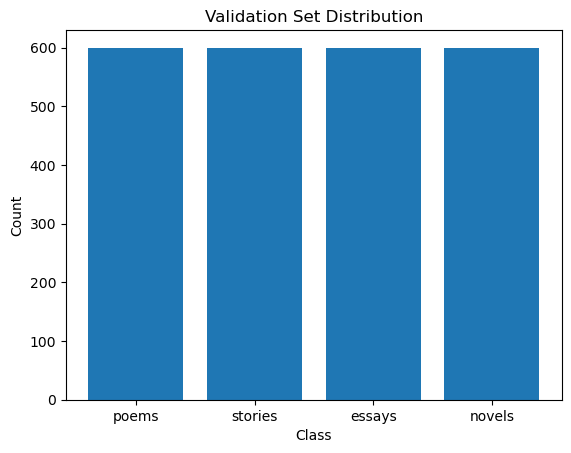

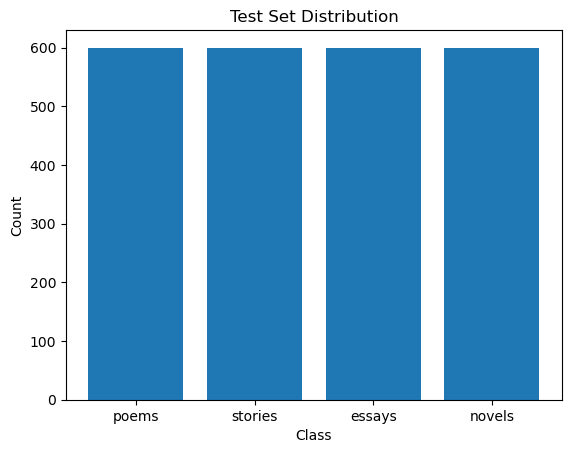

In [5]:
def print_distribution(labels, name):
    counts = Counter(labels)
    print(f"{name} set distribution:")
    for k, v in sorted(counts.items()):
        print(f"  Class {k}: {v}")
    print()

print_distribution(train_labels, "Train")
print_distribution(val_labels, "Validation")
print_distribution(test_labels, "Test")


def plot_distribution(labels, name):
    counts = Counter(labels)
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{name} Set Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0,1,2,3], labels=['poems','stories','essays','novels'])
    plt.show()

plot_distribution(train_labels, "Train")
plot_distribution(val_labels, "Validation")
plot_distribution(test_labels, "Test")


# Tokenizer

In [6]:
if not os.path.exists("bengali_tokenizer"):
    os.makedirs("bengali_tokenizer")  # Ensure the directory exists
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
    tokenizer.save_model("bengali_tokenizer")
else:
    tokenizer = ByteLevelBPETokenizer("bengali_tokenizer/vocab.json", "bengali_tokenizer/merges.txt")

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = BengaliTextDataset(train_texts, train_labels)
val_dataset = BengaliTextDataset(val_texts, val_labels)
test_dataset = BengaliTextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Custom Class

In [7]:
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)


# Training Setup

In [8]:
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size, num_classes=4).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Scheduler (optional warmup + decay)
from transformers import get_cosine_schedule_with_warmup
warmup_steps = 500
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)


In [9]:
def train_epoch():
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)  # Pass input_ids and attention_mask
        loss = loss_fn(outputs, labels)  # Use loss_fn as defined

        loss.backward()
        optimizer.step()
        scheduler.step()  # Add this to update the learning rate

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), accuracy, all_preds, all_labels

# Training

In [13]:
train_losses = []
train_accuracies = []  # Added to store training accuracies
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch()  # Unpack the tuple
    val_loss, val_acc, _, _ = evaluate(val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)  # Store train accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model if it improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), "best_classification_category_bengali_transformer.pt")
        print("Saved new best model.")



Epoch 1/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.96it/s]


Train Loss: 0.8426, Train Acc: 0.6603, Val Loss: 0.8821, Val Acc: 0.6354
Saved new best model.

Epoch 2/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 44.72it/s]


Train Loss: 0.8080, Train Acc: 0.6754, Val Loss: 0.8209, Val Acc: 0.6767
Saved new best model.

Epoch 3/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 47.29it/s]


Train Loss: 1.0798, Train Acc: 0.4823, Val Loss: 1.3864, Val Acc: 0.2500

Epoch 4/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.78it/s]


Train Loss: 1.3872, Train Acc: 0.2496, Val Loss: 1.3865, Val Acc: 0.2500

Epoch 5/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.97it/s]


Train Loss: 1.3869, Train Acc: 0.2520, Val Loss: 1.3869, Val Acc: 0.2500

Epoch 6/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.94it/s]


Train Loss: 1.3870, Train Acc: 0.2427, Val Loss: 1.3864, Val Acc: 0.2500

Epoch 7/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 45.99it/s]


Train Loss: 1.3867, Train Acc: 0.2495, Val Loss: 1.3867, Val Acc: 0.2500

Epoch 8/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 45.57it/s]


Train Loss: 1.3866, Train Acc: 0.2506, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 9/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 45.26it/s]


Train Loss: 1.3866, Train Acc: 0.2486, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 10/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 45.81it/s]


Train Loss: 1.3866, Train Acc: 0.2507, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 11/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 47.06it/s]


Train Loss: 1.3865, Train Acc: 0.2501, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 12/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 44.37it/s]


Train Loss: 1.3867, Train Acc: 0.2520, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 13/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.49it/s]


Train Loss: 1.3866, Train Acc: 0.2497, Val Loss: 1.3864, Val Acc: 0.2500

Epoch 14/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.24it/s]


Train Loss: 1.3865, Train Acc: 0.2477, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 15/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 45.90it/s]


Train Loss: 1.3863, Train Acc: 0.2538, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 16/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 45.96it/s]


Train Loss: 1.3863, Train Acc: 0.2537, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 17/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 44.86it/s]


Train Loss: 1.3865, Train Acc: 0.2467, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 18/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 44.57it/s]


Train Loss: 1.3863, Train Acc: 0.2492, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 19/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 43.81it/s]


Train Loss: 1.3863, Train Acc: 0.2515, Val Loss: 1.3863, Val Acc: 0.2500

Epoch 20/20


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 46.99it/s]

Train Loss: 1.3863, Train Acc: 0.2530, Val Loss: 1.3863, Val Acc: 0.2500


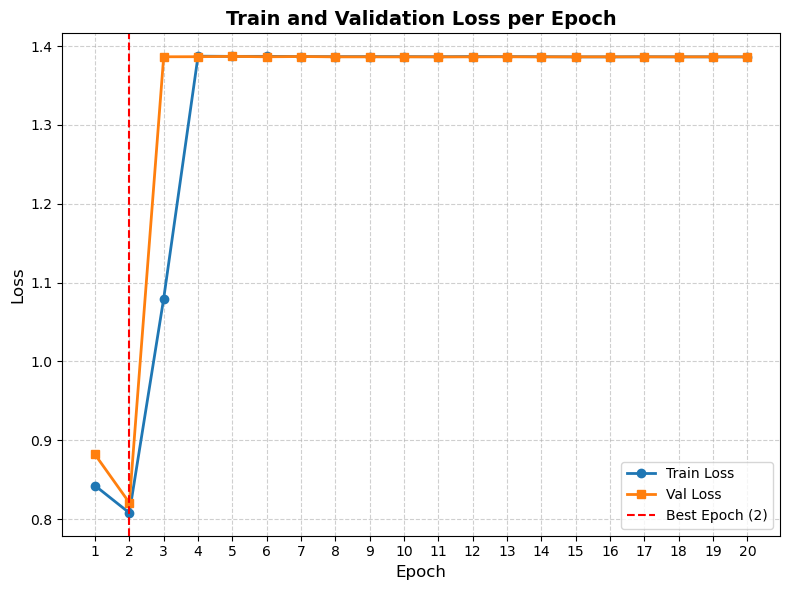

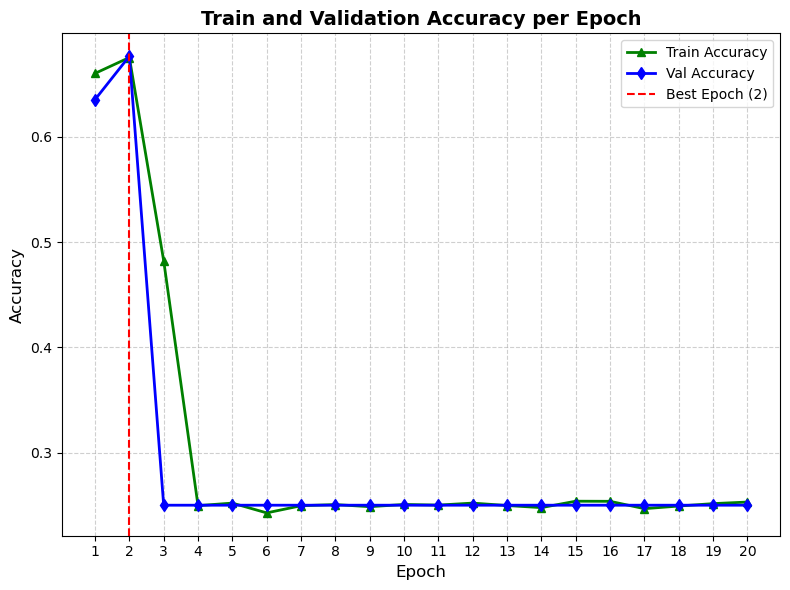

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# --- Plot 1: Train and Validation Loss ---
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(epochs, val_losses, label='Val Loss', marker='s', linewidth=2)
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', linewidth=1.5,
            label=f'Best Epoch ({best_epoch + 1})')
plt.title("Train and Validation Loss per Epoch", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("training_validation_loss.png", dpi=300)
plt.show()

# --- Plot 2: Train and Validation Accuracy ---
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='^', color='g', linewidth=2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='d', color='b', linewidth=2)
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', linewidth=1.5,
            label=f'Best Epoch ({best_epoch + 1})')
plt.title("Train and Validation Accuracy per Epoch", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("training_validation_accuracy.png", dpi=300)
plt.show()


In [28]:
import torch

# Load best model weights
model.load_state_dict(torch.load("best_classification_category_bengali_transformer.pt"))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Evaluating: 100%|██████████| 75/75 [00:01<00:00, 47.32it/s]

Test Loss: 0.7984, Test Accuracy: 0.6854


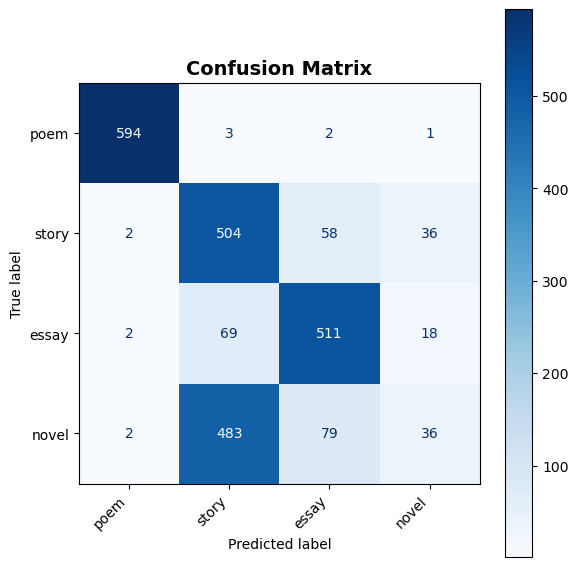

Classification Report:
              precision    recall  f1-score   support

        poem     0.9900    0.9900    0.9900       600
       story     0.4759    0.8400    0.6076       600
       essay     0.7862    0.8517    0.8176       600
       novel     0.3956    0.0600    0.1042       600

    accuracy                         0.6854      2400
   macro avg     0.6619    0.6854    0.6298      2400
weighted avg     0.6619    0.6854    0.6298      2400



In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define class names
class_names = ["poem", "story", "essay", "novel"]

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix with better style
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, colorbar=True)

plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# Print classification report with label names
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))
